In [814]:
# (C) Copyright Aaron Goldberg, 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [815]:
# Implementing idea from https://doi.org/10.1103/PhysRevLett.128.160501. Let's use n=2, amplify a squeezed state, and vary the gain coefficient by varying the beam splitter transmissivity. Other n will take longer
import strawberryfields as sf
from strawberryfields.ops import Sgate, Rgate, BSgate, MeasureFock
from strawberryfields.tdm import borealis_gbs, full_compile, get_mode_indices
import numpy as np

In [816]:
# Compilation will make sure the specs match an actual device, so must be done using a particular device and its characteristics
eng = sf.RemoteEngine("borealis")
device = eng.device

In [817]:
print(device.certificate) # Tells us the loss parameters, squeezing parameters. The best detector seems to always be the 12th, ie index 11
print('The 12th detector has efficiency: ',device.certificate['relative_channel_efficiencies'][11])

{'finished_at': '2023-05-23T14:51:40.209773+00:00', 'target': 'borealis', 'loop_phases': [1.29, 0.173, 1.979], 'schmidt_number': 1.159, 'common_efficiency': 0.37, 'loop_efficiencies': [0.879, 0.883, 0.796], 'squeezing_parameters_mean': {'low': 0.71, 'high': 1.178, 'medium': 0.991}, 'relative_channel_efficiencies': [0.918, 0.936, 0.916, 1.0, 0.966, 0.923, 0.895, 0.969, 0.948, 0.955, 0.973, 0.996, 0.954, 0.972, 0.949, 0.899]}
The 12th detector has efficiency:  0.996


In [818]:
# Let's define our circuit manually
modes = 22 # Only really need 15
starting_mode = 0 # This can be modified if we are aiming for some particular detectors that are better than the rest)

squeeze_level = "high"

# squeezing-gate parameters. These will be rounded to the closest one supported by hardware
r = [0.] * modes

# rotation-gate parameters. These phases will not matter for the photon counting multiplexing we are doing here
phi_0 = [0.] * modes
phi_1 = [0.] * modes
phi_2 = [0.] * modes


# beamsplitter parameters. Set irrelevant transmission parameters to 1 to load all loops
T_0 = [1.] * modes
T_1 = [1.] * modes
T_2 = [1.] * modes


# Create a two-mode squeezed vacuum in the first two modes by interfering two single-mode squeezed vacuum states
r[0+starting_mode] = device.certificate["squeezing_parameters_mean"][squeeze_level] 
r[1+starting_mode] = device.certificate["squeezing_parameters_mean"][squeeze_level]

# symmetric BS will convert two SV into one TMSV
T_0[1+starting_mode] = 0.5 


# Will postselect mode 0 to be in state |n> to herald mode 1 as starting in state |n>

# Create a state to be amplified; here it's a single-mode squeezed vacuum
r[2+starting_mode] = device.certificate["squeezing_parameters_mean"][squeeze_level]
# Delay the state psi in mode 2 to be amplified (all of the squeezed states needed to be in the first modes)
T_0[2+starting_mode] = 1.
delay_length = 11
T_0[2+starting_mode+1:2+starting_mode+1+delay_length] = [0. for i in range(delay_length)]
T_0[2+starting_mode+1+delay_length+1] = 1. # Just to make sure it gets out


# Fixing phases
#phi_0[8]= np.pi/2
#phi_1[1] = np.pi
phi_0[1+starting_mode+1:2+starting_mode+1+delay_length] = [-np.pi/2 for i in range(delay_length+1)] # The delays add phases too, even though they're just identity transformations



# Amplification starts by a variable-transmissivity beam splitter between a vacuum state in mode 7 and the state |n> in mode 1. Will measure mode 1 as amplified state
gain = 128.0
tau = (1./gain)**2/(1.+(1./gain)**2)
tau = 1./(1.+gain**2)
print("tau is", tau)
# We actually want the mode 1 to house the amplified state, which requires an extra swap relative to the paper
# So we adjust the BS accordingly. This does a1-> sqrt(1-tau)a1-sqrt(tau)a2
phi_1[1+starting_mode] += np.pi/2 # To fix the default phases from the beam splitter
T_1[7+starting_mode] = 1.-tau 
phi_2[1+starting_mode] += -np.pi/2 # To fix the default phases from the beam splitter



# Next do QFT on modes 7, 2 delayed to 13, and 14. Then postselect on pattern 0,1,1 to get amplified state, but also will get the same state with different phases if postselect on 1,1,0 or 1,0,1, so that's good too.
# The first BS does a13 -> sqrt(1/2)a13-sqrt(1/2)a14. Our phase choice will end up just adding a global phase
T_0[14+starting_mode] = 0.5
phi_0[2+starting_mode] += -np.pi/2 # Fix the phase. Since this must happen before going into the loop, that happened way back in time bin 2, which then remained in the loop for a long time
phi_1[13+starting_mode] += np.pi/2 # Fix phase after exiting loop.

phi_1[7]+=np.pi
#phi_1[13]+=np.pi/2
#phi_0[2+starting_mode] += np.pi/2


# Now delay mode 14 an appropriate length so that it can intefere at the second loop
delay_length2 = 5
T_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [0. for i in range(delay_length2)]
T_0[14+starting_mode+1+delay_length2+1] = 1. # Just to make sure it gets out
phi_0[14+starting_mode+1:14+starting_mode+1+delay_length2] = [-np.pi/2 for i in range(delay_length2)]
phi_1[19]+=-np.pi/2

phi_0[2]+=-np.pi/2
phi_0[8]+=-np.pi/2
phi_0[14]+=-np.pi/2
phi_2[7]+=np.pi/2
phi_2[13]+=np.pi/2
phi_2[19]+=-np.pi/2
# Beam splitter between modes 7 and 13 at second loop
phi_1[7+starting_mode] += np.pi/2 
T_1[13+starting_mode] = 1./3  ### this one is not affecting anything yet
phi_2[7+starting_mode] += -np.pi/2

# Put phase on mode 14 that is now in mode 19
phi_1[19]+=np.pi*3./2.




# BS between modes 13 and 19 at second loop
phi_1[19+starting_mode] += np.pi/2 # This will cancel with the one from before, anyway 
T_1[19+starting_mode] = 0.5
phi_2[19+starting_mode] += -np.pi/2

# Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
# amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there



alpha_0 = np.arccos(np.sqrt(T_0))
alpha_1 = np.arccos(np.sqrt(T_1))
alpha_2 = np.arccos(np.sqrt(T_2))

# the travel time per delay line in time bins
delay_0, delay_1, delay_2 = 1, 6, 36

# set the first beamsplitter arguments to 'T=1' ('alpha=0') to fill the
# loops with pulses
alpha_0[:delay_0] = 0.0
alpha_1[:delay_1] = 0.0
alpha_2[:delay_2] = 0.0

# The gate arguments need to be defined as lists, so if they were defined with numpy we need to cast them to lists
gate_args = {
    "Sgate": r,
    "loops": {
        0: {"Rgate": phi_0, "BSgate": alpha_0.tolist()},
        1: {"Rgate": phi_1, "BSgate": alpha_1.tolist()},
        2: {"Rgate": phi_2, "BSgate": alpha_2.tolist()},
    },
}

tau is 6.1031431187061336e-05


In [819]:
# Now compile:
gate_args_list = full_compile(gate_args, device)

In [820]:
# Verify components if desired
print(gate_args_list[0])
#gate_args_list[0][0:modes]=r
#print(gate_args_list[0])

[1.178, 1.178, 1.178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [821]:
print(phi_0)
print(gate_args_list[1])
print(phi_1)
print(gate_args_list[3])
#print(len(gate_args_list[3]))
#gate_args_list[3][0:modes]=phi_1
#gate_args_list[3][modes+1:]=[0. for i in range(len(gate_args_list[3][modes+1:-1]))]
#print(gate_args_list[3])
#print(len(gate_args_list[3]))
print(phi_2)
print(gate_args_list[5])
#print(len(gate_args_list[5]))
#gate_args_list[5]=[0. for i in range(len(gate_args_list[5]))]
#print(gate_args_list[5])
#print(len(gate_args_list[5]))

[0.0, 0.0, -4.71238898038469, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -3.141592653589793, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, 0.0, 0.0]
[0.0, 0.0, -4.71238898038469, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -3.141592653589793, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0, 0.0, 4.71238898038469, 0.0, 0.0, 

In [822]:
print(device.certificate["loop_phases"])

[1.29, 0.173, 1.979]


In [823]:
delays = [1, 6, 36]
vac_modes = sum(delays)

n, N = get_mode_indices(delays)
print(vac_modes)
print(n,N)

43
[43 42 36  0] 44


In [824]:
# Use this if want to manually add realistic losses gleaned from the device characteristics, can then be tweaked
eta_glob = device.certificate["common_efficiency"]
etas_loop = device.certificate["loop_efficiencies"]
etas_ch_rel = device.certificate["relative_channel_efficiencies"]

prog_length = len(gate_args_list[0])
reps = int(np.ceil(prog_length / 16))
etas_ch_rel = np.tile(etas_ch_rel, reps)[:prog_length]
etas_ch_rel = etas_ch_rel.tolist()

gate_args_list += [etas_ch_rel]

from strawberryfields.ops import LossChannel
print("minimum loss for any mode is: ", 1-eta_glob)

minimum loss for any mode is:  0.63


In [825]:
prog = sf.TDMProgram(N)

with prog.context(*gate_args_list) as (p, q):
    Sgate(p[0]) | q[n[0]]
    #LossChannel(eta_glob) | q[n[0]]
    for i in range(len(delays)):
        Rgate(p[2 * i + 1]) | q[n[i]]
        BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
        #LossChannel(etas_loop[i]) | q[n[i]]
    #LossChannel(p[7]) | q[0]
    MeasureFock() | q[0]

The transfer matrix is:  [[ 0.707+0.j    -0.   +0.707j  0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j   ]
 [-0.   -0.707j -0.707+0.j    -0.   -0.j     0.   -0.j    -0.   -0.j
  -0.   +0.j     0.   +0.j     0.   -0.j     0.008+0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   -0.j    -1.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.   -0.j     0.   -0.j

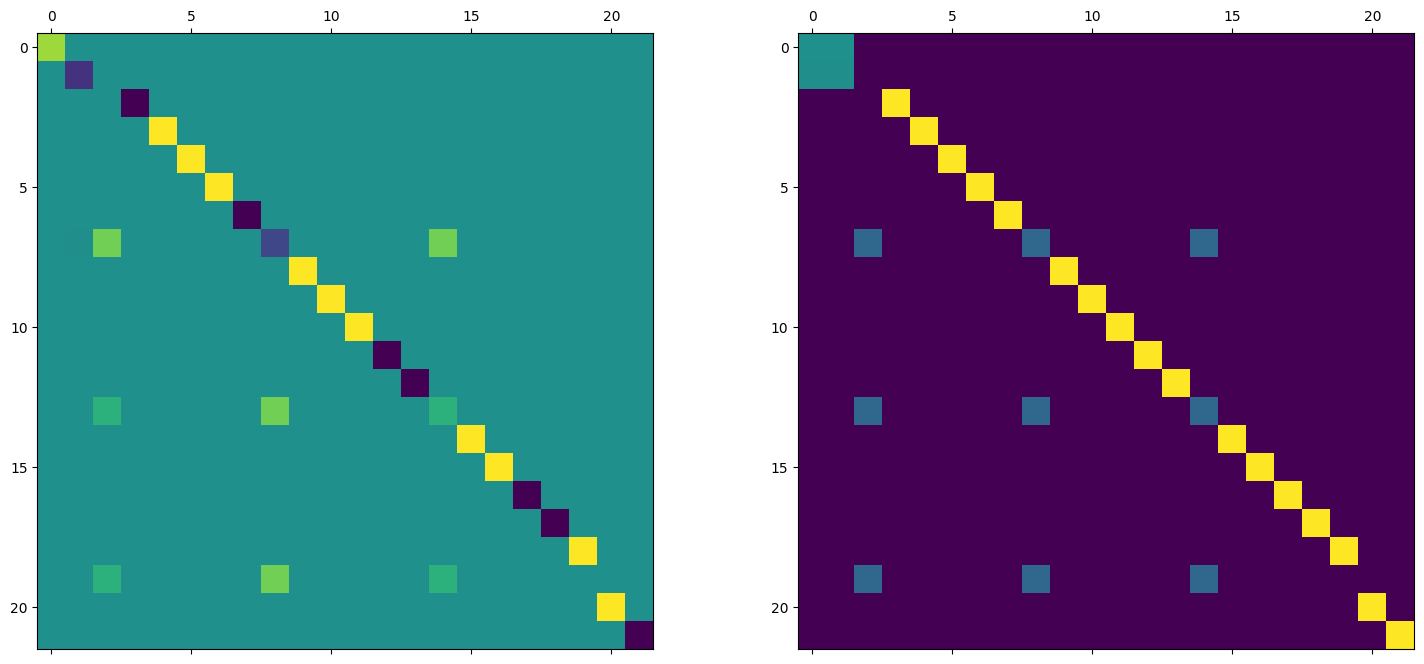

In [826]:
# Let's check the transfer matrix for the relevant modes
prog_passive = sf.TDMProgram(N)
with prog_passive.context(*gate_args_list) as (p, q):
    for i in range(len(delays)):
        Rgate(p[2 * i + 1]) | q[n[i]]
        BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
prog_passive.space_unroll()
prog_passive = prog_passive.compile(compiler="passive")
transfer_matrix_tot = prog_passive.circuit[0].op.p[0]
# crop out the vacuum modes
transfer_matrix = transfer_matrix_tot[vac_modes:prog_length, vac_modes:prog_length]
print("The transfer matrix is: ", transfer_matrix.round(3))
#print(transfer_matrix_tot.round(15))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].matshow(transfer_matrix.real)
ax[1].matshow(transfer_matrix.imag**2)
ax[1].matshow(transfer_matrix.real**2+transfer_matrix.imag**2)
plt.show()

In [827]:
transfer_matrix.round(2)[[0,1,7,13,19],:]

array([[ 0.71+0.j  , -0.  +0.71j,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ],
       [-0.  -0.71j, -0.71+0.j  , -0.  -0.j  ,  0.  -0.j  , -0.  -0.j  ,
        -0.  +0.j  ,  0.  +0.j  ,  0.  -0.j  ,  0.01+0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ],
       [-0.  -0.j  , -0.  +0.j  ,  0.58-0.j  ,  0.  +0.j  ,  0.  -0.j  ,
        -0.  -0.j  , -0.  +0.j  ,  0.  +0.j  , -0.58-0.j  , -0.  -0.j  ,
        -0.  +0.j  ,  0.  +0.j  ,  0.  -0.j  , -0.  -0.j  ,  0.58+0.j  ,
         0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,
         0.  +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  

In [828]:
transfer_matrix.round(3)[:,0:3]

array([[ 0.707+0.j   , -0.   +0.707j,  0.   +0.j   ],
       [-0.   -0.707j, -0.707+0.j   , -0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   , -0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   , -0.   -0.j   ],
       [-0.   -0.003j, -0.003+0.j   ,  0.577-0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   , -0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.003j,  0.003-0.j   ,  0.289+0.5j  ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   , -0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.   +0.j   , -0.   +0.j   ],
       [ 0.   +0.j   ,  0.  

In [841]:
compile_options = {
    "device": device,
    "realistic_loss": False,
}
run_options = {
    "shots": 0,
    "crop": True,
    "space_unroll": True,
}

eng_sim = sf.Engine(backend="gaussian")
results_sim = eng_sim.run(prog, **run_options, compile_options=compile_options) # Using automated loss
#results_sim = eng_sim.run(prog, shots=None, space_unroll=True, crop=True) # Using manual loss from specific device

In [842]:
state = results_sim.state
print("Number of modes: ",state.num_modes)
high_cutoff=40
low_cutoff=40
mode0=state.reduced_dm(0,cutoff=high_cutoff) #This does some weird things when the cutoff is too small!
print("trace, purity of mode 0 calculated with Fock (faulty!): ",np.trace(mode0),np.trace(np.matmul(mode0,mode0)))
mode1=state.reduced_dm(1,cutoff=high_cutoff) #This does some weird things when the cutoff is too small!
print("trace, purity of mode 1 calculated with Fock (faulty!): ",np.trace(mode1),np.trace(np.matmul(mode1,mode1)))
gauss0=state.reduced_gaussian(0)
gauss1=state.reduced_gaussian(1)

# If I make a state using the covariance matrix and means listed above, I get the wrong answer
from thewalrus.quantum import state_vector, density_matrix
mu0=gauss0[0]
cov0=gauss0[1]
#psi0 = state_vector(mu0, cov0, normalize=False, cutoff=low_cutoff) # Can only use this for pure states
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)
#print(psi0) # Can only use this for pure states
#print(np.diag(rho0))
#print(np.diag(mode0))
mu1=gauss1[0]
cov1=gauss1[1]
#psi1 = state_vector(mu1, cov1, normalize=False, cutoff=low_cutoff) # Can only use this for pure states
rho1 = density_matrix(mu1, cov1, normalize=False, cutoff=low_cutoff)
#print(psi1) # Can only use this for pure states
#print(rho1)
#print(mode1)
print("Quadrature coherence scale from mode 0:",1.+2*np.sum([n*((-1)**n) * rho0[n][n] for n in range(low_cutoff)])/np.sum([((-1)**n) * rho0[n][n] for n in range(low_cutoff)]))
print("Quadrature coherence scale from mode 1:",1.+2*np.sum([n*((-1)**n) * rho1[n][n] for n in range(low_cutoff)])/np.sum([((-1)**n) * rho1[n][n] for n in range(low_cutoff)]))
print("If it was pure we'd have QCS of 1+2 nbar:",1.+2.*np.sinh(gate_args_list[0][0])**2)
print("nbar",np.sum([n * rho1[n][n] for n in range(low_cutoff)]))
print("purity of initial state from output Fock",np.sum([((-1)**n) * rho1[n][n] for n in range(low_cutoff)]))
print("g^2(0) mode 0:",np.sum([n*(n-1)*rho0[n][n] for n in range(low_cutoff)])/(np.sum([n * rho0[n][n] for n in range(low_cutoff)])**2))
print("g^2(0) mode 1:",np.sum([n*n*rho1[n][n] for n in range(low_cutoff)])/(np.sum([n * rho1[n][n] for n in range(low_cutoff)])**2)-1/(np.sum([n * rho0[n][n] for n in range(low_cutoff)])))

Number of modes:  22
trace, purity of mode 0 calculated with Fock (faulty!):  (1+0j) (1+0j)
trace, purity of mode 1 calculated with Fock (faulty!):  (1+0j) (1+0j)
Quadrature coherence scale from mode 0: (0.18788885821886592+0j)
Quadrature coherence scale from mode 1: (0.18789818727682261+0j)
If it was pure we'd have QCS of 1+2 nbar: 5.321735460918713
nbar (2.1607254396939677+0j)
purity of initial state from output Fock (0.18791789369784742+0j)
g^2(0) mode 0: (1.9999270867986456+0j)
g^2(0) mode 1: (1.9999553777940329+0j)


In [843]:
[print(state.reduced_gaussian(i)) for i in range(modes)];

(array([-0.,  0.]), array([[5.32173546e+00, 3.08227243e-16],
       [3.08227243e-16, 5.32173546e+00]]))
(array([-0.,  0.]), array([[5.32147170e+00, 3.93292577e-16],
       [3.93292577e-16, 5.32147170e+00]]))
(array([-0.,  0.]), array([[ 1.00000000e+00, -1.42807774e-32],
       [-1.42807774e-32,  1.00000000e+00]]))
(array([-0.,  0.]), array([[1.00000000e+00, 1.42807774e-32],
       [1.42807774e-32, 1.00000000e+00]]))
(array([-0.,  0.]), array([[ 1.00000000e+00, -1.42807774e-32],
       [-1.42807774e-32,  1.00000000e+00]]))
(array([-0.,  0.]), array([[1.00000000e+00, 1.42807774e-32],
       [1.42807774e-32, 1.00000000e+00]]))
(array([-0.,  0.]), array([[ 1.00000000e+00, -1.42807774e-32],
       [-1.42807774e-32,  1.00000000e+00]]))
(array([-0.,  0.]), array([[3.63387773, 1.26960576],
       [1.26960576, 1.24745509]]))
(array([-0.,  0.]), array([[ 1.00000000e+00, -1.42807774e-32],
       [-1.42807774e-32,  1.00000000e+00]]))
(array([-0.,  0.]), array([[1.00000000e+00, 1.42807774e-32],
   

In [844]:
reduced_state=state.reduced_gaussian([0,1,7,13,19])
from thewalrus.quantum import state_vector, density_matrix
mu0=reduced_state[0]
cov0=reduced_state[1]
low_cutoff=3
rho0 = density_matrix(mu0, cov0, normalize=False, cutoff=low_cutoff)

In [845]:
rho0[2,2,1,1,0,0,1,1,1,1]

(-1.6410875180603977e-17-4.918832621120768e-19j)

In [846]:
# Finally, postselect on mode 19 having a 1, mode 13 having a 1, mode 7 having a 0. Already said to postselect on n=2 in mode 0. 
# amplified state is in mode 1, so we will look at the (conditional) photon-number distribution there
max_photon_out = low_cutoff
amplified_probs = [0. for i in range(max_photon_out)]
for j in range(max_photon_out):
    locations = [2,j,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Since we expect no population to go to the other modes, we can postselect on them being 0
    amplified_probs[j] = state.fock_prob(locations[0:modes],cutoff=100) 
# Can use any of the options 011, 110, 101 for the modes 7,13,19 since we aren't measuring the phase
amplified_probs1 = [0. for i in range(max_photon_out)]
for j in range(max_photon_out):
    amplified_probs1[j] = rho0[2,2,j,j,0,0,1,1,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
amplified_probs2 = [0. for i in range(max_photon_out)]
for j in range(max_photon_out):
    amplified_probs2[j] = rho0[2,2,j,j,1,1,1,1,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
amplified_probs3 = [0. for i in range(max_photon_out)]
for j in range(max_photon_out):
    amplified_probs3[j] = rho0[2,2,j,j,1,1,0,0,1,1] # This explicitly finds the reduced density matrix first and then calculates the probabilities, in case other modes had nonzero photons
print(amplified_probs)
print(amplified_probs1)
print(amplified_probs2)
print(amplified_probs3)

[6.883809337848093e-11, 0.0, 0.006316268412072775]
[(6.883809337848096e-11-1.337784365707803e-26j), (-1.6410875180603977e-17-4.918832621120768e-19j), (0.006316268412072775-1.3296026854991968e-18j)]
[(-1.5289514187129398e-26-1.6310373250920497e-26j), (-2.011625446153236e-31-7.597698597305409e-33j), (7.743580279262073e-17+6.072802325978316e-19j)]
[(6.883809337874366e-11-2.4062954575504706e-26j), (-1.6409605221499747e-17-4.914907968962144e-19j), (0.0063162684120727786-4.5686354717314465e-19j)]


In [847]:
print(amplified_probs/np.sum(amplified_probs))
print((amplified_probs3/np.sum(amplified_probs3)).round(8)) # Same results

[1.08985382e-08 0.00000000e+00 9.99999989e-01]
[ 1.0000000e-08-0.j -0.0000000e+00-0.j  9.9999999e-01+0.j]


In [848]:
expected_probs = [gain**(2*2*i) *np.tanh(device.certificate["squeezing_parameters_mean"][squeeze_level])**(2*i)*np.math.factorial(2*i)
                  /2**(2*i)/np.math.factorial(i)**2/np.cosh(device.certificate["squeezing_parameters_mean"][squeeze_level]) 
                  for i in range(2)]
expected_probs=expected_probs/np.sum(expected_probs)
print("coefficients squared of 0 and 2 expected to be",expected_probs)
print("coefficients squared of 0 and 2 expected to be",[1, np.tanh(device.certificate["squeezing_parameters_mean"][squeeze_level])**2 * gain**(4)/2]/np.sum([1, np.tanh(device.certificate["squeezing_parameters_mean"][squeeze_level])**2 * gain**4/2]))
print("original coefficients of 0 and 2 proportional to",[1, np.tanh(device.certificate["squeezing_parameters_mean"][squeeze_level])*np.sqrt(2.)/2])

coefficients squared of 0 and 2 expected to be [1.08985382e-08 9.99999989e-01]
coefficients squared of 0 and 2 expected to be [1.08985382e-08 9.99999989e-01]
original coefficients of 0 and 2 proportional to [1, 0.5846499714022251]


In [849]:
print("If we did 10^6 shots, we'd get this many counts each ",np.array(amplified_probs)*10**6)

If we did 10^6 shots, we'd get this many counts each  [6.88380934e-05 0.00000000e+00 6.31626841e+03]


In [850]:
print("If we did 10^6 shots with realistic loss, we'd get this many counts each ",np.array(amplified_probs)*10**6)

If we did 10^6 shots with realistic loss, we'd get this many counts each  [6.88380934e-05 0.00000000e+00 6.31626841e+03]


In [839]:
"""
Try keeping high squeezing and realistic loss. 
gain=0.5:
If we did 10^6 shots, we'd get this many counts each  [1500.97275333  330.80267081   40.69541463]
gain=1.0:
If we did 10^6 shots, we'd get this many counts each  [609.01194959 331.33865256  99.82766589]
gain=2.0:
If we did 10^6 shots, we'd get this many counts each  [144.28171331 123.35024494  56.72674886]
gain=4.0:
If we did 10^6 shots, we'd get this many counts each  [49.9175033  49.58047001 24.97119894]
gain=8.0:
If we did 10^6 shots, we'd get this many counts each  [35.11835823 36.43712781 18.53805078]
gain=128.0:
If we did 10^6 shots, we'd get this many counts each  [31.41969676 33.1295807  16.92692573]
"""

"\nTry keeping high squeezing and realistic loss. \ngain=0.5:\nIf we did 10^6 shots, we'd get this many counts each  [1500.97275333  330.80267081   40.69541463]\ngain=1.0:\nIf we did 10^6 shots, we'd get this many counts each  [609.01194959 331.33865256  99.82766589]\ngain=2.0:\nIf we did 10^6 shots, we'd get this many counts each  [144.28171331 123.35024494  56.72674886]\ngain=4.0:\nIf we did 10^6 shots, we'd get this many counts each  [49.9175033  49.58047001 24.97119894]\ngain=8.0:\nIf we did 10^6 shots, we'd get this many counts each  [35.11835823 36.43712781 18.53805078]\n"

In [840]:
"""for gain of 2
If we did 10^6 shots on low without realistic loss, we'd get this many counts each  [ 613.86270014    0.         1831.4038439 ]
If we did 10^6 shots on medium without realistic loss, we'd get this many counts each  [ 814.29466275    0.         3740.82580494]
If we did 10^6 shots on high without realistic loss, we'd get this many counts each  [ 739.23362967    0.         4042.90525726]

If we did 10^6 shots on low with realistic loss, we'd get this many counts each  [11.01867203  4.86578831  1.0675028 ]
If we did 10^6 shots on medium with realistic loss, we'd get this many counts each  [63.32142567 43.90530077 15.9632532 ]
If we did 10^6 shots on high with realistic loss, we'd get this many counts each  [144.28171331 123.35024494  56.72674886]
"""

"for gain of 2\nIf we did 10^6 shots on low without realistic loss, we'd get this many counts each  [ 613.86270014    0.         1831.4038439 ]\nIf we did 10^6 shots on medium without realistic loss, we'd get this many counts each  [ 814.29466275    0.         3740.82580494]\nIf we did 10^6 shots on high without realistic loss, we'd get this many counts each  [ 739.23362967    0.         4042.90525726]\n\nIf we did 10^6 shots on low with realistic loss, we'd get this many counts each  [11.01867203  4.86578831  1.0675028 ]\nIf we did 10^6 shots on medium with realistic loss, we'd get this many counts each  [63.32142567 43.90530077 15.9632532 ]\nIf we did 10^6 shots on high with realistic loss, we'd get this many counts each  [144.28171331 123.35024494  56.72674886]\n"